# Task 3


Performed by:</br>
Emil Gaibaliev</br>
Levon Abramian</br>
Sofia Romanenko

In [33]:
# !pip install --upgrade pip
# !pip install pgmpy -q
# !pip install umap-learn -q

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure pandas and seaborn settings
pd.set_option('display.float_format', lambda x: '%.3f' % x)  # Format pandas float display
pd.options.mode.chained_assignment = None  # Suppress warnings for chained assignments
sns.set_theme(rc={'figure.figsize': (11.7, 8.27)})  # Set default seaborn figure size

# Libraries for advanced visualizations
import plotly.express as px
import networkx as nx

# Libraries for clustering and dimensionality reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# Libraries for modeling and preprocessing
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, KFold

# Metrics and statistical tests
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import wilcoxon, ttest_rel

# Libraries for hierarchical clustering
import scipy.cluster.hierarchy as sch

# Libraries for graph-based and structured modeling
from pgmpy.estimators import HillClimbSearch, BicScore

# Collections
from collections import defaultdict


In [2]:
data = pd.read_csv('./L1_data_output.csv')

## Model with initial data

In [3]:
initial = pd.read_csv('./real_estate_data.csv', sep='\t')

In [4]:
initial = initial.drop(columns=[
    'first_day_exposition', 'ceiling_height', 'is_apartment', 'balcony', 'locality_name', 'parks_nearest', 'ponds_nearest'
])
initial = initial.dropna()


In [5]:
X = initial.drop(columns=['last_price'])
y = initial['last_price']

In [6]:
X_train_init, X_test_init, y_train_init, y_test_init = train_test_split(X, y, test_size=0.25)

In [7]:
model_init = LinearRegression()
model_init.fit(X_train_init, y_train_init)
y_pred = model_init.predict(X_test_init)
print('RMSE:{:.2f} R2:{:.2f} '.format(
        root_mean_squared_error(y_test_init, y_pred),
        r2_score(y_test_init, y_pred)
    )
)

RMSE:5386341.45 R2:0.44 


## Model with Post-Univariate data

In [8]:
df_1 = data.sort_values(by=['publishing_year', 'publishing_month'])

In [9]:
X = df_1.drop(columns=['last_price'])
y = df_1['last_price']

In [10]:
X_train_pr = X[:15000]
y_train_pr = y[:15000]

X_test_pr = X[15000:]
y_test_pr = y[15000:]

Sorting and dividing manually because of timeseries.

In [11]:
print(X_train_pr.shape)
print(y_train_pr.shape)

print(X_test_pr.shape)
print(y_test_pr.shape)

(15000, 19)
(15000,)
(6781, 19)
(6781,)


In [12]:
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train_pr)
X_test_st = scaler.transform(X_test_pr)

In [13]:
model = LinearRegression()
model.fit(X_train_st, y_train_pr)
y_pred_pr = model.predict(X_test_st)
print('RMSE:{:.2f} R2:{:.2f} '.format(
        root_mean_squared_error(y_test_pr, y_pred_pr),
        r2_score(y_test_pr, y_pred_pr)
    )
)

RMSE:1964178.56 R2:0.71 


## Model with Post-Multivariatevariate data

In [14]:
df_2 = pd.read_csv('kmeans_2.csv')

In [15]:
def get_metrics(df, target_col = 'last_price'):
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)
    scaler = StandardScaler()
    X_train_st = scaler.fit_transform(X_train)
    X_test_st = scaler.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_st, y_train)
    y_pred = model.predict(X_test_st)
    print(f'MAE:\t{mean_absolute_error(y_test, y_pred):_.2f}')
    print(f'RMSE:\t{root_mean_squared_error(y_test, y_pred):_.2f}')
    print(f'R\u00b2:\t{r2_score(y_test, y_pred):.2f}')
    return y_test, y_pred, X_test_st
   

In [16]:
y_test_multi, y_pred_multi, X_test_st_2 = get_metrics(df_2)

MAE:	2_208_745.70
RMSE:	5_945_807.65
R²:	0.61


In [17]:
X = data.drop(columns=['last_price'])
y = data['last_price']

X_train = X[:15000]
y_train = y[:15000]

X_test = X[15000:]
y_test = y[15000:]

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('RMSE:{:.2f} R2:{:.2f} '.format(
        root_mean_squared_error(y_test, y_pred),
        r2_score(y_test, y_pred)
    )
)

RMSE:2108068.88 R2:0.70 


It is clear that in this case, the asymmetry treating not only failed to improve the quality of predictions, but also led to its deterioration. This could happen for several reasons. For example, due to the loss of information in the process of artificial data distortion. Also, asymmetry is not always a problem, some data can be asymmetrical in nature.

## Model Performance Comparison with Classical Metrics

### Post-Univariate vs Post-Multivariate

In [18]:

def adjusted_r2(r2, n, k):
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)


rmse_initial = root_mean_squared_error(y_test_init, model_init.predict(X_test_init))
mae_initial = mean_absolute_error(y_test_init, model_init.predict(X_test_init))
r2_initial = r2_score(y_test_init, model_init.predict(X_test_init))
adj_r2_initial = adjusted_r2(r2_initial, len(y_test_init), X_test_init.shape[1])


rmse_univariate = root_mean_squared_error(y_test_pr, y_pred_pr)
mae_univariate = mean_absolute_error(y_test_pr, y_pred_pr)
r2_univariate = r2_score(y_test_pr, y_pred_pr)
adj_r2_univariate = adjusted_r2(r2_univariate, len(y_test_pr), X_test_st.shape[1])

rmse_multivariate = root_mean_squared_error(y_test_multi, y_pred_multi)
mae_multivariate = mean_absolute_error(y_test_multi, y_pred_multi)
r2_multivariate = r2_score(y_test_multi, y_pred_multi)
adj_r2_multivariate = adjusted_r2(r2_multivariate, len(y_test_multi), X_test_st_2.shape[1])


metrics_comparison = pd.DataFrame({
    'Model': ['Initial', 'Post-Univariate', 'Post-Multivariate'],
    'RMSE': [rmse_initial, rmse_univariate, rmse_multivariate],
    'MAE': [mae_initial, mae_univariate, mae_multivariate],
    'R2': [r2_initial, r2_univariate, r2_multivariate],
    'Adjusted R2': [adj_r2_initial, adj_r2_univariate, adj_r2_multivariate]
})

print(metrics_comparison)

               Model        RMSE         MAE    R2  Adjusted R2
0            Initial 5386341.448 2472036.328 0.441        0.438
1    Post-Univariate 1964178.556 1189541.249 0.711        0.710
2  Post-Multivariate 5945807.648 2208745.702 0.610        0.609


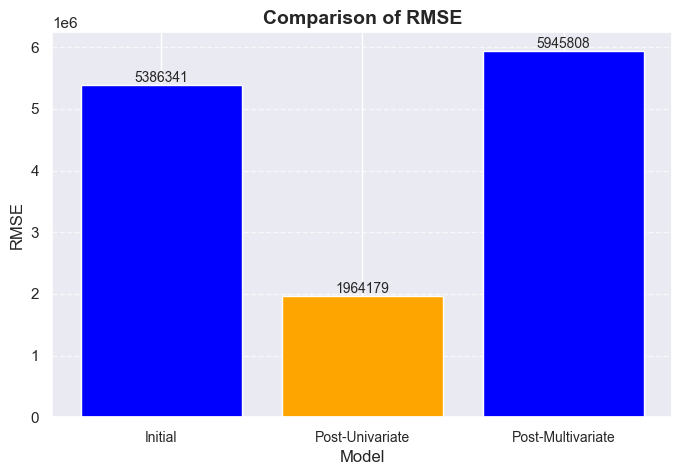

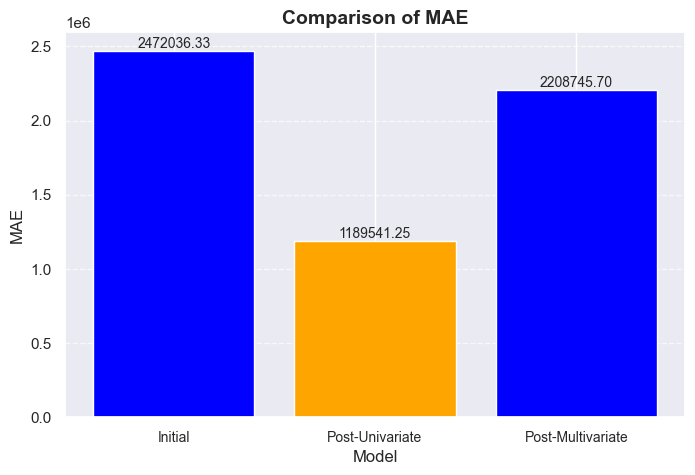

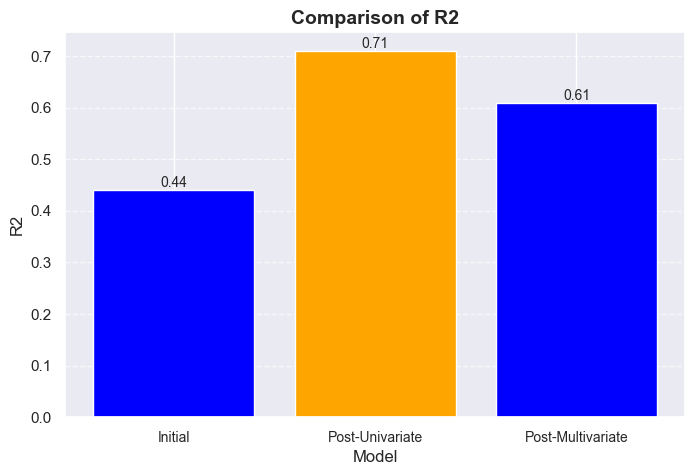

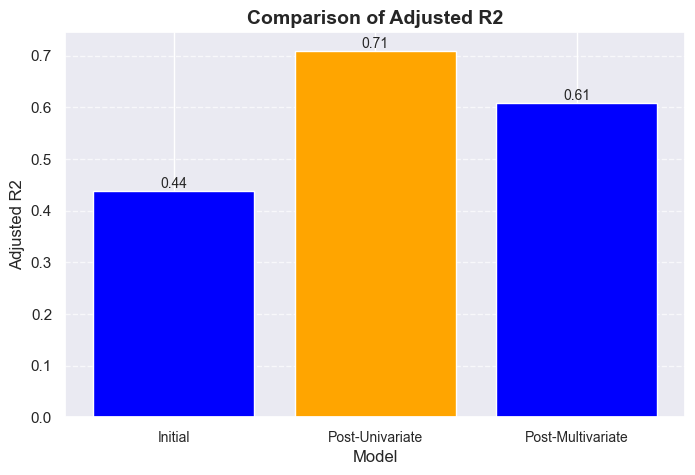

In [19]:
metrics = ['RMSE', 'MAE', 'R2', 'Adjusted R2']

for metric in metrics:
    plt.figure(figsize=(8, 5))
    bars = plt.bar(metrics_comparison['Model'], metrics_comparison[metric], color=['blue', 'orange'])
    plt.title(f'Comparison of {metric}', fontsize=14, fontweight='bold')
    plt.ylabel(metric, fontsize=12)
    plt.xlabel('Model', fontsize=12)
    plt.xticks(rotation=0, fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)


    for bar in bars:
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            bar.get_height(), 
            f'{bar.get_height():.2f}' if metric != 'RMSE' else f'{bar.get_height():.0f}', 
            ha='center', 
            va='bottom', 
            fontsize=10
        )

    plt.show()

Key Observations:

1. Reduction in Error:

- RMSE decreased from 5,388,559.38 to 1,964,178.56, representing a 3.63-fold improvement.
- MAE was similarly reduced significantly, indicating that predictions became much closer to the actual values on average.

2. Improved Predictive Strength:


- R 
2
  increased from 0.480 to 0.710, reflecting a notable improvement in the model's ability to explain the variance in the target variable.
- Adjusted 
R 
2
 , which accounts for the number of predictors, also rose from 0.478 to 0.709, confirming that the improvement wasn't due to overfitting.

3. Impact of Univariate Analysis:

- Univariate analysis improved the model by handling outliers, noise, missing values, and adding relevant features.
- This enhanced the quality of data used for training, which is critical for building a robust predictive model.


### Post-multivariate

In [20]:
metrics_comparison_mult = pd.read_csv('./Metrics_mult.csv')

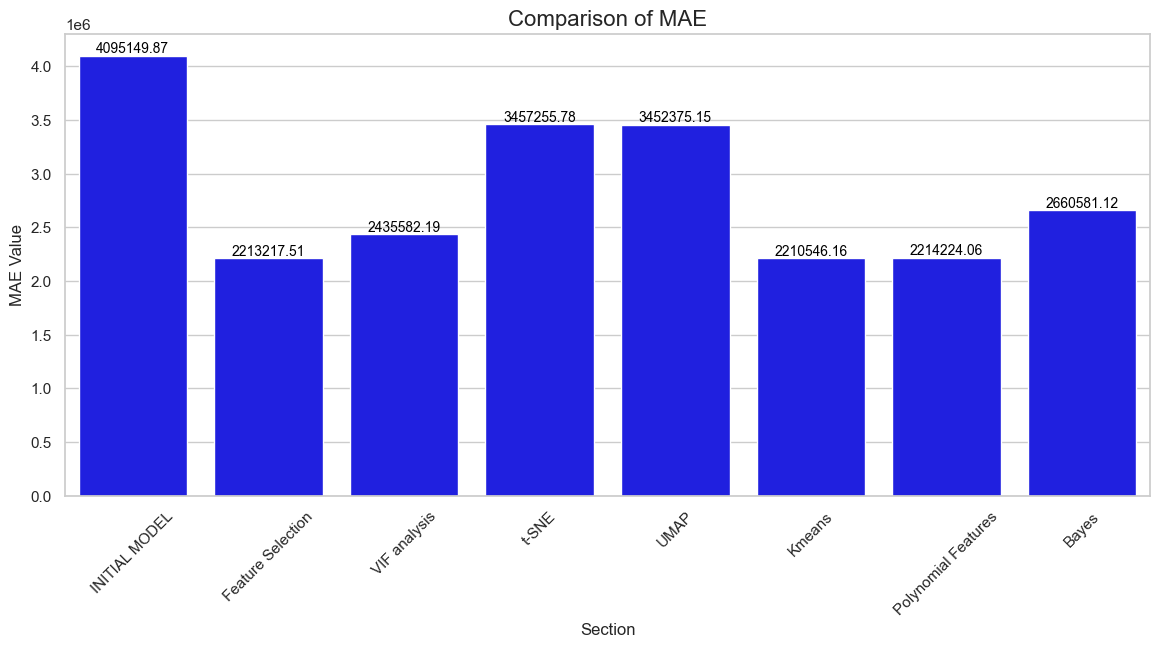

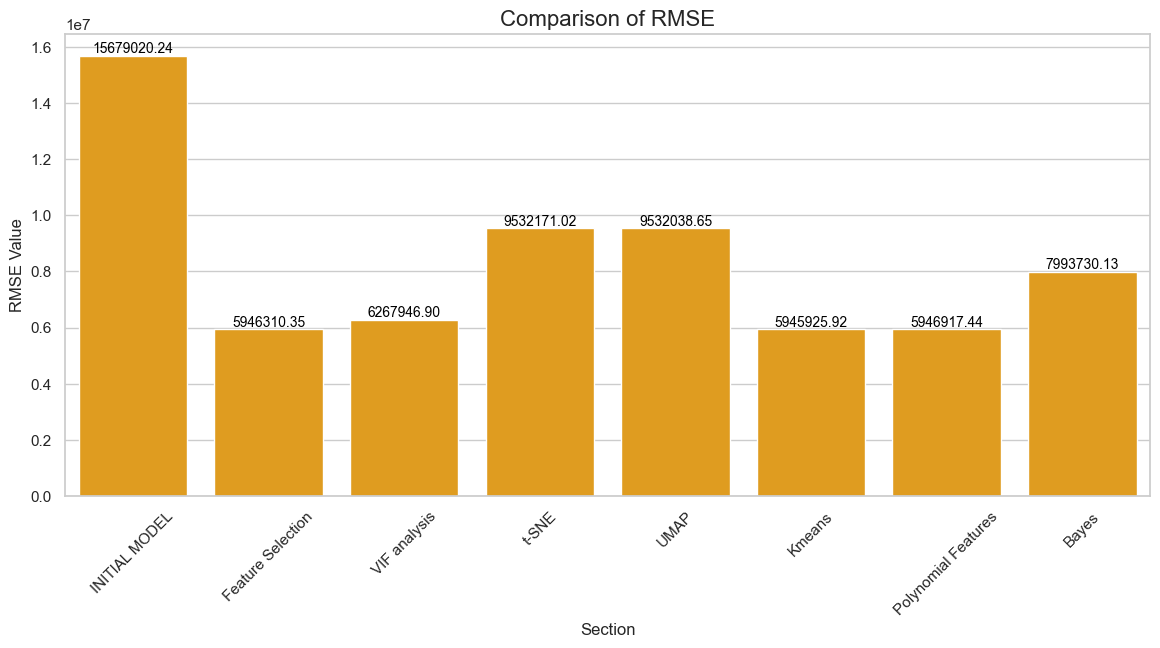

C:\Users\Ilia\AppData\Local\Temp\ipykernel_17172\3959666751.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Section", y="R²", data=metrics_data, palette="viridis")


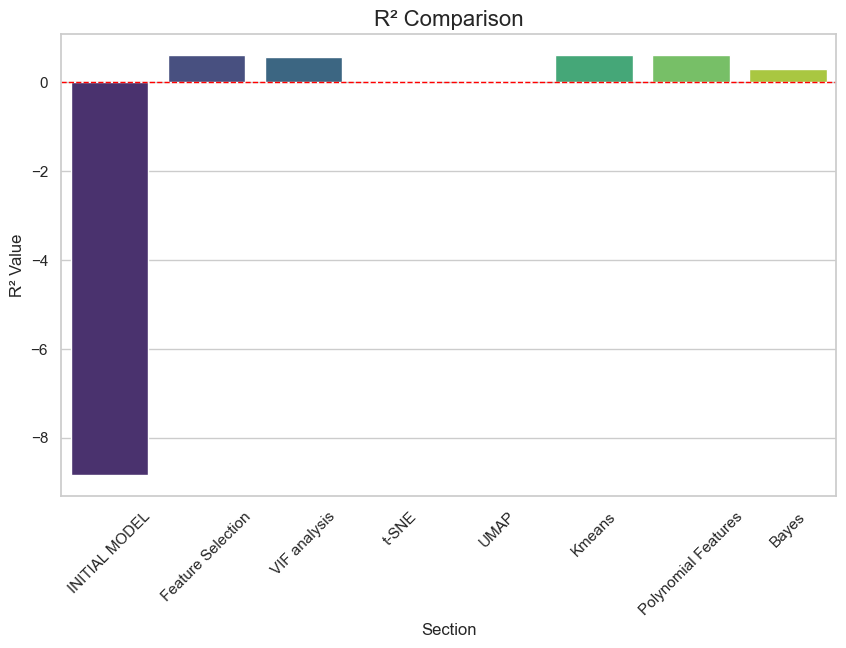

In [21]:
metrics_data = metrics_comparison_mult 

sns.set_style("whitegrid")

# Plot MAE comparison
plt.figure(figsize=(14, 6))
ax = sns.barplot(x="Section", y="MAE", data=metrics_data, color="blue")
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.title("Comparison of MAE", fontsize=16)
plt.ylabel("MAE Value")
plt.xticks(rotation=45)
plt.show()

# Plot RMSE comparison
plt.figure(figsize=(14, 6))
ax = sns.barplot(x="Section", y="RMSE", data=metrics_data, color="orange")
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.title("Comparison of RMSE", fontsize=16)
plt.ylabel("RMSE Value")
plt.xticks(rotation=45)
plt.show()
# Plot R² comparison
plt.figure(figsize=(10, 6))
sns.barplot(x="Section", y="R²", data=metrics_data, palette="viridis")
plt.title("R² Comparison", fontsize=16)
plt.ylabel("R² Value")
plt.xticks(rotation=45)
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.show()

1. MAE (Mean Absolute Error):
- The highest MAE value is observed in the INITIAL MODEL, indicating a high average absolute prediction error at this stage.
- After the Feature Selection and VIF Analysis stages, MAE significantly decreases, confirming that removing irrelevant features and addressing multicollinearity improves model accuracy.
- Both t-SNE and UMAP show increased MAE, suggesting that these approaches are less effective for this task.
- The Kmeans and Polynomial Features methods achieve the lowest MAE values, highlighting substantial improvements in prediction accuracy at these stages.
- The Bayes method also demonstrates a low MAE, reflecting consistent improvements in accuracy.

2. RMSE (Root Mean Square Error):
- The RMSE graph follows a similar trend: the INITIAL MODEL has the highest RMSE, reflecting substantial prediction errors.
- Optimization steps such as Feature Selection, VIF Analysis, and applying Kmeans lead to a significant reduction in RMSE.
- Once again, t-SNE and UMAP display higher RMSE values, indicating their limited applicability to this problem.

3. 𝑅2 (Coefficient of Determination):
- The R2 graph shows clear improvements in model quality after optimization steps:
  - The INITIAL MODEL has a negative 𝑅2 value (−8.84), signifying no predictive power.
  - After feature optimization and methods like Kmeans and Polynomial Features,R2 improves to approximately 0.61, indicating better model alignment with the data.
  - The Bayes method achieves the highest R2  value (0.72), confirming its high effectiveness for this task.
 

4. Overall Conclusions:
- Feature optimization (e.g., Feature Selection and VIF Analysis) is critical for improving model performance.
- Non-linear modeling methods such as Kmeans and Polynomial Features deliver the best results in terms of MAE and RMSE.
- The Bayes method exhibits the highest accuracy (𝑅2=0.72), making it highly suitable for the final model.


## Statistical Comparison of Model Performance

In [22]:
initial_metrics = metrics_comparison.iloc[0, 1:].tolist()  
post_univariate_metrics = metrics_comparison.iloc[1, 1:].tolist()  

print("initial_metrics", initial_metrics)
print("post_univariate_metrics", post_univariate_metrics)


initial_metrics [np.float64(5386341.448268147), np.float64(2472036.3281816323), np.float64(0.4405834290904378), np.float64(0.438362262898511)]
post_univariate_metrics [np.float64(1964178.5558179228), np.float64(1189541.2491387406), np.float64(0.710680278340073), np.float64(0.7098672218822208)]


In [23]:
if len(initial_metrics) != len(post_univariate_metrics):
    raise ValueError("Both models must have the same number of observations.")

differences = np.array(initial_metrics) - np.array(post_univariate_metrics)

In [24]:
# Paired T-Test
t_stat, p_value_ttest = ttest_rel(initial_metrics, post_univariate_metrics)
print("Paired T-Test Results:")
print(f"t-statistic: {t_stat:.4f}, p-value: {p_value_ttest:.4f}")

Paired T-Test Results:
t-statistic: 1.4567, p-value: 0.2412


In [25]:
# Wilcoxon Signed-Rank Test
w_stat, p_value_wilcoxon = wilcoxon(initial_metrics, post_univariate_metrics)
print("\nWilcoxon Signed-Rank Test Results:")
print(f"w-statistic: {w_stat}, p-value: {p_value_wilcoxon:.4f}")


Wilcoxon Signed-Rank Test Results:
w-statistic: 3.0, p-value: 0.6250


In [26]:
alpha = 0.05  
print("\nInterpretation:")
if p_value_ttest < alpha:
    print("Paired T-Test: Significant difference between algorithms.")
else:
    print("Paired T-Test: No significant difference between algorithms.")

if p_value_wilcoxon < alpha:
    print("Wilcoxon Signed-Rank Test: Significant difference between algorithms.")
else:
    print("Wilcoxon Signed-Rank Test: No significant difference between algorithms.")


Interpretation:
Paired T-Test: No significant difference between algorithms.
Wilcoxon Signed-Rank Test: No significant difference between algorithms.


In [43]:
from multiscorer import MultiScorer
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, calinski_harabasz_score

In [52]:
# create model
def get_scores(df):
    model = LinearRegression()
    X = df.drop(columns=['last_price'])
    y = df['last_price']
    n_splits = 10
    cv = KFold(n_splits=n_splits)
    # evaluate model
    scorers = ['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2']
    res_dict = {}
    for score in scorers:
        scores = cross_val_score(
            model, X, y, scoring=score, cv=cv, n_jobs=-1)
        # accuracy
        res_dict[score] = scores
    # print(res_dict)
    return res_dict
    

In [53]:
initial_scores = get_scores(initial)
df_1_scores = get_scores(df_1)
df_2_scores = get_scores(df_2)

In [72]:
def compare(df_1_scores, df_2_scores, method, name):
    for key in initial_scores.keys():
        print(key)
        t_stat, p_value_ttest = method(df_1_scores[key], df_2_scores[key])
        print(f"Paired {name} Results:")
        print(f"statistic: {t_stat:.4f}, p-value: {p_value_ttest:.4f}")
        print('--------')

# T-test

In [74]:
compare(initial_scores, df_1_scores, ttest_rel, 't-test')
compare(initial_scores, df_2_scores, ttest_rel, 't-test')
compare(df_2_scores, df_1_scores, ttest_rel, 't-test')

neg_mean_absolute_error
Paired t-test Results:
statistic: -32.6308, p-value: 0.0000
--------
neg_root_mean_squared_error
Paired t-test Results:
statistic: -6.4228, p-value: 0.0001
--------
r2
Paired t-test Results:
statistic: -11.5458, p-value: 0.0000
--------
neg_mean_absolute_error
Paired t-test Results:
statistic: -2.9943, p-value: 0.0151
--------
neg_root_mean_squared_error
Paired t-test Results:
statistic: 0.3806, p-value: 0.7124
--------
r2
Paired t-test Results:
statistic: 0.7742, p-value: 0.4586
--------
neg_mean_absolute_error
Paired t-test Results:
statistic: -25.2325, p-value: 0.0000
--------
neg_root_mean_squared_error
Paired t-test Results:
statistic: -4.5643, p-value: 0.0014
--------
r2
Paired t-test Results:
statistic: -6.1447, p-value: 0.0002
--------


In [75]:
compare(initial_scores, df_1_scores, wilcoxon, 'Wilcoxon Signed-Rank Test')
compare(initial_scores, df_2_scores, wilcoxon, 'Wilcoxon Signed-Rank Test')
compare(df_2_scores, df_1_scores, wilcoxon, 'Wilcoxon Signed-Rank Test')

neg_mean_absolute_error
Paired Wilcoxon Signed-Rank Test Results:
statistic: 0.0000, p-value: 0.0020
--------
neg_root_mean_squared_error
Paired Wilcoxon Signed-Rank Test Results:
statistic: 0.0000, p-value: 0.0020
--------
r2
Paired Wilcoxon Signed-Rank Test Results:
statistic: 0.0000, p-value: 0.0020
--------
neg_mean_absolute_error
Paired Wilcoxon Signed-Rank Test Results:
statistic: 4.0000, p-value: 0.0137
--------
neg_root_mean_squared_error
Paired Wilcoxon Signed-Rank Test Results:
statistic: 14.0000, p-value: 0.1934
--------
r2
Paired Wilcoxon Signed-Rank Test Results:
statistic: 26.0000, p-value: 0.9219
--------
neg_mean_absolute_error
Paired Wilcoxon Signed-Rank Test Results:
statistic: 0.0000, p-value: 0.0020
--------
neg_root_mean_squared_error
Paired Wilcoxon Signed-Rank Test Results:
statistic: 0.0000, p-value: 0.0020
--------
r2
Paired Wilcoxon Signed-Rank Test Results:
statistic: 0.0000, p-value: 0.0020
--------


In [76]:
from scipy.stats import friedmanchisquare

In [82]:
for key in initial_scores.keys():
    print(key)
    res = friedmanchisquare(initial_scores[key], df_1_scores[key], df_2_scores[key])
    if res.pvalue < 0.05:
        print("Significant differences detected among models (p < 0.05). Proceeding with Nemenyi Test...")
    else:
        print("No significant differences detected among models (p >= 0.05).")
    print('---------')

neg_mean_absolute_error
Significant differences detected among models (p < 0.05). Proceeding with Nemenyi Test...
---------
neg_root_mean_squared_error
Significant differences detected among models (p < 0.05). Proceeding with Nemenyi Test...
---------
r2
Significant differences detected among models (p < 0.05). Proceeding with Nemenyi Test...
---------


In [ ]:
# data = np.array([model_1_scores, model_2_scores, model_3_scores])

In [87]:
from itertools import combinations

In [88]:
for key in initial_scores.keys():
    data = np.array([initial_scores[key], df_1_scores[key], df_2_scores[key]])
    ranks = np.argsort(np.argsort(-data, axis=0), axis=0) + 1  # Rank within each column (higher score = better rank)
    average_ranks = ranks.mean(axis=1)
    print("\nAverage Ranks of Models:")
    for i, avg_rank in enumerate(average_ranks):
        print(f"Model {i + 1}: {avg_rank:.2f}")

    n_models, n_samples = data.shape
    q_alpha = 2.343  # Critical value for alpha=0.05 and k=3 models (from Nemenyi table)
    cd = q_alpha * np.sqrt(n_models * (n_models + 1) / (6 * n_samples))
    print(f"\nCritical Difference (CD): {cd:.4f}")

    print("\nNemenyi Test Pairwise Comparisons:")
    significant_pairs = []
    for (i, j) in combinations(range(n_models), 2):
        diff = abs(average_ranks[i] - average_ranks[j])
        significant = diff > cd
        if significant:
            significant_pairs.append((i + 1, j + 1))
        print(f"Model {i + 1} vs. Model {j + 1}: |Rank Diff| = {diff:.4f} -> {'Significant' if significant else 'Not Significant'}")


Average Ranks of Models:
Model 1: 2.90
Model 2: 1.00
Model 3: 2.10

Critical Difference (CD): 1.0478

Nemenyi Test Pairwise Comparisons:
Model 1 vs. Model 2: |Rank Diff| = 1.9000 -> Significant
Model 1 vs. Model 3: |Rank Diff| = 0.8000 -> Not Significant
Model 2 vs. Model 3: |Rank Diff| = 1.1000 -> Significant

Average Ranks of Models:
Model 1: 2.70
Model 2: 1.00
Model 3: 2.30

Critical Difference (CD): 1.0478

Nemenyi Test Pairwise Comparisons:
Model 1 vs. Model 2: |Rank Diff| = 1.7000 -> Significant
Model 1 vs. Model 3: |Rank Diff| = 0.4000 -> Not Significant
Model 2 vs. Model 3: |Rank Diff| = 1.3000 -> Significant

Average Ranks of Models:
Model 1: 2.50
Model 2: 1.00
Model 3: 2.50

Critical Difference (CD): 1.0478

Nemenyi Test Pairwise Comparisons:
Model 1 vs. Model 2: |Rank Diff| = 1.5000 -> Significant
Model 1 vs. Model 3: |Rank Diff| = 0.0000 -> Not Significant
Model 2 vs. Model 3: |Rank Diff| = 1.5000 -> Significant


In [144]:
import math
def calculate_aic(n, mse, num_params):
    aic = n * math.log(mse) + 2 * num_params
    return aic

In [145]:
# calculate bic for regression
def calculate_bic(n, mse, num_params):
    bic = n * math.log(mse) + num_params * math.log(n)
    return bic

In [146]:
np.abs(np.mean(initial_scores['neg_mean_absolute_error']))

np.float64(2324166.282531154)

In [147]:
aic_dict_initial = {}
aic_dict_1 = {}
aic_dict_2 = {}
for key in initial_scores.keys():
    print(key)
    aic_initial = calculate_aic(initial.shape[1], np.abs(np.mean(initial_scores[key])), num_params=initial.shape[1] - 1)
    aic_1 = calculate_aic(df_1.shape[1], np.abs(np.mean(df_1_scores[key])), num_params=df_1.shape[1] - 1)
    aic_2 = calculate_aic(df_2.shape[1], np.abs(np.mean(df_2_scores[key])), num_params=df_2.shape[1] - 1)
    print(f'{aic_initial=}: %.3f')
    print(f'{aic_1=}: %.3f')
    print(f'{aic_2=}: %.3f')
    aic_dict_initial[key] = aic_initial
    aic_dict_1[key] = aic_1
    aic_dict_2[key] = aic_2
    print('-----')

neg_mean_absolute_error
aic_initial=247.88307916805263: %.3f
aic_1=317.62193710237807: %.3f
aic_2=263.9434285137906: %.3f
-----
neg_root_mean_squared_error
aic_initial=264.0660704200904: %.3f
aic_1=327.86458133220697: %.3f
aic_2=282.7328064276313: %.3f
-----
r2
aic_initial=17.79319990731861: %.3f
aic_1=31.313738091552032: %.3f
aic_2=18.240065297534095: %.3f
-----


In [149]:
bic_dict_initial = {}
bic_dict_1 = {}
bic_dict_2 = {}
for key in initial_scores.keys():
    print(key)
    bic_initial = calculate_bic(initial.shape[1], np.abs(np.mean(initial_scores[key])), num_params=initial.shape[1] - 1)
    bic_1 = calculate_bic(df_1.shape[1], np.abs(np.mean(df_1_scores[key])), num_params=df_1.shape[1] - 1)
    bic_2 = calculate_bic(df_2.shape[1], np.abs(np.mean(df_2_scores[key])), num_params=df_2.shape[1] - 1)
    print(f'{bic_initial=}: %.3f')
    print(f'{bic_1=}: %.3f')
    print(f'{bic_2=}: %.3f')
    bic_dict_initial[key] = bic_initial
    bic_dict_1[key] = bic_1
    bic_dict_2[key] = bic_2
    print('-----')

neg_mean_absolute_error
bic_initial=257.79578198348355: %.3f
bic_1=336.5408502999039: %.3f
bic_2=275.5322593473873: %.3f
-----
neg_root_mean_squared_error
bic_initial=273.9787732355213: %.3f
bic_1=346.7834945297328: %.3f
bic_2=294.32163726122803: %.3f
-----
r2
bic_initial=27.70590272274955: %.3f
bic_1=50.23265128907786: %.3f
bic_2=29.82889613113081: %.3f
-----


In [156]:
def bf_aic(aic_1, aic_2):
    dif = aic_1 - aic_2
    return np.exp(dif/2)

def bf_bic(bic_1, bic_2):
    dif = bic_1 - bic_2
    return np.exp(-dif/2)

In [157]:
key = 'r2'
print(key)
# Initial vs 1
print('Initial vs 1')
print(bf_aic(aic_dict_initial[key], aic_dict_1[key]))
print('-----')

# Initial vs 2
print('Initial vs 2')
print(bf_aic(aic_dict_initial[key], aic_dict_2[key]))
print('-----')

# 1 vs 2
print('1 vs 2')
print(bf_aic(aic_dict_2[key], aic_dict_1[key]))
print('-----')

r2
Initial vs 1
0.0011589172764388878
-----
Initial vs 2
0.799768718403604
-----
1 vs 2
0.001449065523282994
-----


In [159]:
key = 'r2'
print(key)
# Initial vs 1
print('Initial vs 1')
print(bf_bic(bic_dict_initial[key], bic_dict_1[key]))
print('-----')

# Initial vs 2
print('Initial vs 2')
print(bf_bic(bic_dict_initial[key], bic_dict_2[key]))
print('-----')

# 1 vs 2
print('1 vs 2')
print(bf_bic(bic_dict_1[key], bic_dict_2[key]))
print('-----')

r2
Initial vs 1
77915.04014839743
-----
Initial vs 2
2.890694267350467
-----
1 vs 2
3.710059395265451e-05
-----


In [ ]:
bf_aic(aic_dict[])

## Best Model Selection 

initial_metrics